In [13]:
import numpy as np
import pandas as pd
from collections import Counter
from Data import load_data

rng = np.random.default_rng(117)

# Use field goals attempted and points per game since they should be positively correlated
# Can use 2p and 3p later since they should be negatively correlated
players, obj1, obj2, weights = load_data("Player", "PS/G▼", "TOV", "SALARY")
print(obj2)

[3.3 4.6 3.5 3.8 3.3 3.2 2.  2.2 4.3 3.3 2.7 1.7 2.4 2.4 1.5 2.  2.1 2.5
 2.2 3.5 4.1 2.5 2.3 3.4 1.5 2.6 1.5 2.7 2.8 1.1 2.2 2.3 1.9 1.3 2.  2.3
 2.  2.  2.4 2.6 2.6 2.3 2.3 2.7 1.  1.9 1.8 2.1 2.8 1.7 1.5 1.5 1.4 2.9
 1.6 1.9 2.9 1.4 1.4 1.6 1.7 1.7 1.4 1.1 2.6 1.5 2.3 1.8 3.2 1.9 2.1 2.5
 2.3 1.6 1.6 1.6 2.5 1.2 1.2 2.1 2.9 3.2 1.4 1.4 1.1 1.4 1.4 1.1 1.3 2.
 1.1 2.1 1.8 3.9 1.4 1.1 1.5 0.9 1.2 1.9 0.8 1.8 2.8 1.5 1.8 1.5 1.  2.4
 1.2 1.1 2.3 1.5 2.4 1.3 1.7 0.9 2.1 1.  1.8 1.6 1.3 1.1 1.5 1.2 1.7 2.5
 1.6 1.3 1.1 1.3 0.6 1.4 0.6 0.7 1.5 1.4 0.8 1.7 0.9 1.5 0.7 1.  0.8 1.3
 1.2 1.9 1.3 1.9 1.8 0.9 1.3 1.3 0.8 1.  0.9 1.3 1.  0.9 0.9 1.5 1.1 1.8
 1.6 1.1 1.3 1.2 1.3 3.6 1.4 1.7 1.  1.4 1.6 1.4 1.  0.9 1.2 1.5 0.6 1.7
 1.2 0.7 1.  0.9 1.5 1.1 1.2 1.9 0.3 0.8 0.6 0.6 1.  1.4 0.8 0.9 0.9 0.8
 1.2 0.9 0.9 0.5 0.8 0.7 1.1 1.2 0.9 1.2 0.7 0.8 0.6 0.6 0.7 0.7 0.8 1.3
 0.8 0.9 1.2 0.8 1.  0.9 0.6 1.2 0.6 0.5 0.6 1.2 0.8 0.9 0.9 1.  1.  1.1
 0.9 1.3 0.9 1.1 1.4 0.7 1.7 0.6 0.8 1.1 0.6 0.3 0.7

In [14]:
# Create a population of num_teams x team_size, with random values from 0-last index
# Each individual represents a team, and each team has 15 players
def initializePopulation(num_teams, team_size, max_index):
    return rng.integers(0, max_index, (num_teams, team_size), dtype=int)

def calculateValue(individual, obj):
    return np.sum(obj[individual])

def calculateWeight(individual, weights):
    return np.sum(weights[individual])

# Sets the fitness to -inf if the weight exceeds the knapsack capacity, or if there are duplicate players (can't draft the same player twice)
# Otherwise, sets the fitness to the value of the team
# Since there is a limit on how many players can be in each team, don't use value to weight ratio as the fitness
def calculateFitness(individual, weights, obj1, obj2, epsilon, capacity):
    indevidual_weight = calculateWeight(individual, weights)
    count = Counter(individual)

    # If the weight exceeds the capacity or the second objective is less than the constraint
    if (indevidual_weight > capacity) or (calculateValue(individual, obj2) > epsilon):
        fitness = -np.inf
    else:
        fitness = calculateValue(individual, obj1)

    # If the same player is chosen twice, punish
    for i in range(len(individual)):
        if count[individual[i]] > 1: 
            fitness = -np.inf
            break
    return fitness

# Selects the two best as the parents
def selectParents(capacity, weights, obj1, obj2, epsilon, population):
    fitness = []
    for individual in population:
        fitness.append(calculateFitness(individual, weights, obj1, obj2, epsilon, capacity))

    fitness = np.array(fitness)
    top_indices = np.argsort(fitness)[-2:] 
    return [population[top_indices[0]], population[top_indices[1]]]

# Generates a population of the same size as the initial population
# Selects each gene randomly from one of the parents
def generatePopulation(parents, pop_size, team_size, mutation_rate, length):
    population = np.zeros((pop_size, team_size), dtype=int)
    population[0], population[1] = parents

    for i in range(2, pop_size):
        for j in range(team_size):
            parent_choice = rng.integers(0, 2)
            population[i][j] = parents[parent_choice][j]
            
            # Mutation
            if rng.random() < mutation_rate:
                population[i][j] = rng.integers(0, length)
    return population


# Creates an initial population
# Saves the mean value for the population in each training iteration to plot
# Finds to two best as parents
# Creates a new population using the parents
# Saves only the valid solutions in the final population and returns the one with the highest value

# Make objectives be *args and make it dynamic
def knapSackGenetic(capacity, weights, obj1, obj2, epsilon, training_length, pop_size, team_size):
    max_index = len(weights) - 1
    population = initializePopulation(pop_size, team_size, max_index)

    #vals = []
    for i in range(training_length):
        #vals.append(np.mean([val for val in [calculateValue(ind, values) for ind in population]]))

        parents = selectParents(capacity, weights, obj1, obj2, epsilon, population)
        population = generatePopulation(parents, pop_size, team_size, .01, max_index)
    
    valid = []
    for individual in population:
        print(f"Weight: {calculateWeight(individual, weights):,}")
        print(f"Obj2 value: {calculateValue(individual, obj2)}")
        if calculateFitness(individual, weights, obj1, obj2, epsilon, capacity) == -np.inf: continue
        valid.append(individual)

    valid = np.array(valid)
    if len(valid) == 0:
        print("No solutions")
        return -1
    else:
        print("Success")
    indices = np.argsort([val for val in [calculateValue(ind, obj1) for ind in valid]])
    return valid[indices[-1]]


In [ ]:
# Constrain obj2, optimize obj1 (fga and ppg respectively)

# FGA is not performing well, could be due to the correlation, test more with positive and negative correlated variables
epsilon = 15
capacity = 150_000_000
training_length = 500
pop_size = 100
team_size = 15
individual = knapSackGenetic(capacity, weights, obj1, obj2, epsilon, training_length, pop_size, team_size)

if np.any(individual != -1):
    individual = np.sort(individual)
    print(f"Best Solution: {individual}")
    print(f"Points: {calculateValue(individual, obj1)}")
    print(f"TOV: {calculateValue(individual, obj2)}")
    #print(f"Value: {calculateValue(individual, values)} | Weight: {calculateWeight(individual, weights):,}\n")

Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 113,725,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 120,837,360
Obj2 value: 14.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 116,425,565
Obj2 value: 15.1
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
Weight: 122,475,565
Obj2 value: 15.0
W

NameError: name 'vals' is not defined

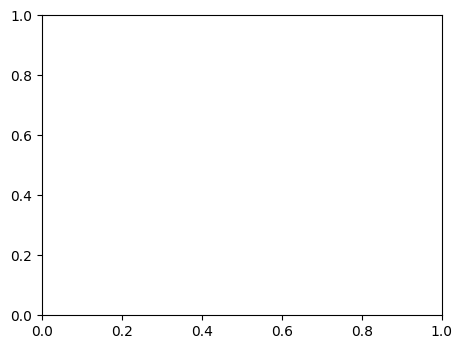

In [16]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(4, 3))
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(vals)
ax.grid(True)
ax.set_xticks(np.arange(0, len(vals) + 1, 25))
ax.set_yticks(np.arange(100, 400, 25))
ax.set_title("Points Increase Across Generations")
ax.set_ylabel("Total Points")
ax.set_xlabel("Generation Number")
plt.show()
print(f"Starting Value: {vals[0]}")
print(f"Ending Value: {vals[-1]}")
print(f"Max value: {np.max(vals)}")

